In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform


%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [6]:
bounding_polygon= gpd.read_file('watershed_shp/watershed.shp')
interior_polygon= gpd.read_file('watershed_shp/watershed.shp')
# bounding_polygon= gpd.read_file('area/domain.shp')
# Elevation Data
# topography_file = 'DEM.tif'
topography_file = '/hydros/ZhiLi/demHouston033s_NAm83.tif'
# topography_file= '/home/ZhiLi/CRESTHH/data/precip/imerg20170825S150000.tif'

# Resolution for most of the mesh
base_resolution = 10  # m^2


In [3]:
# lons= np.array(bounding_polygon.exterior[0].coords)[:,0]; lats=np.array(bounding_polygon.exterior[0].coords)[:,1]
lons= np.array(bounding_polygon.exterior[1].coords)[:,0]; lats=np.array(bounding_polygon.exterior[1].coords)[:,1]

In [4]:
myProj = Proj("+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [5]:
utm_coords= [myProj(lon,lat) for (lon, lat) in zip(lons, lats)]

[]
Figure files for each frame will be stored in _plot


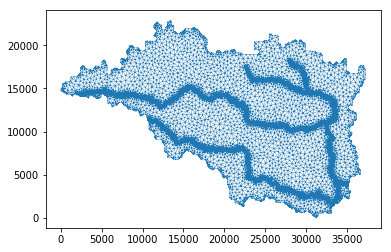

In [2]:
# domain = anuga.create_domain_from_regions(
#             utm_coords,
#             boundary_tags={'bottom': [0]},
#             maximum_triangle_area=1000000,
            
#             )

domain= anuga.create_domain_from_file('../Sensitivity/original_08076700.msh')

# domain= anuga.create_domain_from_rectangular()

# Basic geometry and bounding polygon
# xleft   = -95.05
# xright  = -95.83
# ybottom = 29.79
# ytop    = 30.18

# point_sw = [xleft, ybottom]
# point_se = [xright, ybottom]
# point_nw = [xleft, ytop]    
# point_ne = [xright, ytop]

# bounding_polygon = [point_se,
#                     point_ne,
#                     point_nw,
#                     point_sw]


# domain= anuga.create_domain_from_regions(bounding_polygon,boundary_tags={'bottom': [0],},maximum_triangle_area=0.0005)

# domain= anuga.rectangular_cross_domain

domain.set_name('excessive_rain') # Name of sww file
dplotter = anuga.Domain_plotter(domain)  
plt.triplot(dplotter.triang, linewidth = 0.4);

In [7]:
domain.areas.max()**0.5

399.83989056365846

In [7]:
print 'Number of elements:',domain.number_of_elements

Number of elements: 63854


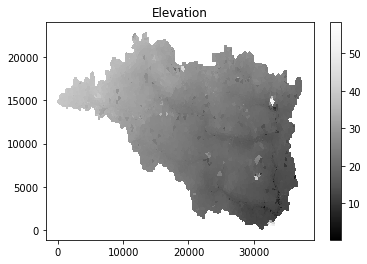

In [7]:
start= '20170826050000'
end= '20170829000000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids')                        # Constant friction 
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.01, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/ef5_param/crest_params/ksat_usa.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/ef5_param/crest_params/wm_usa.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/ef5_param/crest_params/b_usa.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/ef5_param/crest_params/im_usa.tif', location='centroids')
domain.set_quantity('KE', 0.5, location='centroids')
domain.set_infiltration(False)
domain.set_coupled(True)

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/hydros/MengyuChen/mrmsPrecRate',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('2M')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()

plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')
plt.colorbar();
plt.title("Elevation");

In [8]:
domain.set_quantity('stage',filename='/hydros/ZhiLi/CREST-iMAP-DL/output/simu/surR.20170829_0000.crest.tif')

ValueError: the input file is inside the boundary, please crop with a larger extent

In [9]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'exterior': Bi})

In [ ]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=total_seconds)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
#     dplotter.save_depth_frame(vmin=0, vmax=30)
#     domain.print_operator_timestepping_statistics()
    domain.print_timestepping_statistics()
#     domain.report_water_volume_statistics()

    stage = domain.get_quantity('stage')
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral() 
# Read in the png files stored during the evolve loop
# dplotter.make_depth_animation() 

Time = 2017-08-26 05:00:00, steps=0 (24s)
integral =  0.0
Time = 2017-08-26 05:02:00, delta t in [0.89186780, 0.93078574], steps=133 (9s)
integral =  292.4667392734589
rain rate: 0.0000, evaporation rate: 0.0000  infiltration rate: 0.0000
Time = 2017-08-26 05:04:00, delta t in [0.90003304, 0.90053324], steps=134 (9s)
integral =  467.7356100363404
rain rate: 0.0000, evaporation rate: 0.0000  infiltration rate: 0.0000
Time = 2017-08-26 05:06:00, delta t in [0.89993973, 0.90098396], steps=134 (11s)
integral =  592.200941255228
rain rate: 0.0001, evaporation rate: 0.0000  infiltration rate: 0.0000
Time = 2017-08-26 05:08:00, delta t in [0.90099824, 0.90517168], steps=133 (12s)
integral =  654.8529705094364


In [ ]:
343/100

In [ ]:
# splotter = anuga.SWW_plotter('excessive_rain.sww')

In [ ]:
# plt.plot(splotter.depth[1:,iloc])

In [ ]:
# domain.quantities['yvelocity'].plot_quantity()

In [ ]:
# from matplotlib import animation
# ani= dplotter.make_depth_animation()
# mywriter = animation.FFMpegWriter(fps=1)
# ani.save('/home/ZhiLi/myanimation.gif')


In [ ]:
#read from existing sww file
swwfile = '../calibration/best.sww'
splotter = anuga.SWW_plotter(swwfile)
# for i,time in enumerate(splotter.time):
#     splotter.save_depth_frame(frame=i)
#     print(time)
# splotter.make_depth_animation()

## Validate with observational data

from netCDF4 import Dataset

OBS= pd.read_csv('/home/ZhiLi/CRESTHH/data/streamGauge/08068500.txt', delimiter='\t',
                 names=['USGS','ID','date','TZ','Q',' ','H',' '], converters={'date':pd.to_datetime}).set_index('date')
OBS.index= OBS.index.tz_localize('US/Central').tz_convert('UTC').tz_localize(None)

from pyproj import Proj, CRS, transform
proj= "+proj=utm +zone=15, +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs"
wgs84= CRS('EPSG:4326')
UTM= CRS(proj)
GAUGE_LOC= (-95.43666, 30.11085)
to_utm_x, to_utm_y= transform(UTM,wgs84,GAUGE_LOC[0], GAUGE_LOC[1])

speed= splotter.speed
depth= splotter.stage
# to_utm_x, to_utm_y= myProj(GAUGE_LOC[1], GAUGE_LOC[0])

xc = splotter.xc + splotter.xllcorner
yc = splotter.yc + splotter.yllcorner
iloc= np.argmin( (xc-to_utm_x)**2 + (yc-to_utm_y)**2 )
sim= depth[:,iloc]
# obs= OBS.resample('1H', label='right').mean().loc[pd.date_range(start,
#                 end, freq='1H'),'H']
obs= OBS.resample('1H', label='right').mean().loc[pd.date_range('201704010500',
                 '201709010000', freq='1H'),'H']

speed= splotter.speed
to_utm_x, to_utm_y= myProj(GAUGE_LOC[0], GAUGE_LOC[1])

xc = splotter.xc + splotter.xllcorner
yc = splotter.yc + splotter.yllcorner
iloc= np.argmin( (xc-to_utm_x)**2 + (yc-to_utm_y)**2 )
sim= speed[:,iloc]*domain.areas[iloc]
obs= OBS.resample('1H', label='right').mean().loc[pd.date_range('20170401050000',
                '20170901000000', freq='1H'),'Q']

df = pd.DataFrame(index= dr)
df['sim']= sim
df['obs']= obs*0.0283168

# 3D plot animation